# The problem of choosing the location of a coffee shop in the Toronto Neighborhood 

*week1*

## **The description of the problem and a discussion of the background**

**Question:** Which place is more appropriate to open a coffee shop in the Toronto Neighborhood? A coffee shop owner wants to open a new coffee shop in the Toronto Neighborhood. He needs to know where to choose and will have a higher probability of getting customers?

**Background:** First explain that everything is hypothetical. On a train, I had a communication with a coffee shop owner. I learned from the communication that the coffee shop owner wanted to expand his store in the Toronto Neighborhood, and he wanted to know which communities in Toronto are more suitable for opening coffee shops. Because the boss is more anxious and has no cost considerations, professional data such as passenger flow, regional economy, and regional population types cannot be obtained, and can only be analyzed with the help of Internet information. 

## The description of the data and how it will be used to solve the problem

**Data description:** Considering the time and cost issues, I chose to obtain data from the Internet. The composition of the data is mainly divided into two parts:

+ Toronto Neighborhood information, which mainly includes community name and community Geo information.
+ Toronto Neighborhood venue distribution information, the main information includes: the venue belongs to the Neighborhood information, place type, place name

**Problem-solving ideas:** Through statistical analysis of the distribution of coffee shops in all communities in Toronto, we look for communities with relatively few coffee shops for selection. While selecting objects, it is also necessary to observe the actual number of shops in the community to avoid the validity of the calculated data in the real environment. 

In [11]:
!pip install pandas numpy
!pip install geopy
!pip install folium
import pandas as pd
import numpy as np
import requests 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import geopy
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: Cryptograp

*week2*

## Introduction where you discuss the business problem and who would be interested in this project

**Business question:** Which place to open a coffee shop in the Toronto Neighborhood is more appropriate. A coffee shop owner wants to open a new coffee shop in the Toronto Neighborhood. He needs to know where to choose and will have a higher probability of getting customers?

**Understanding of the problem:** According to the conventional understanding, choosing a Neighborhood with a small number of coffee shops to open a store will have a higher probability of acquiring customers. Therefore, the business problem can be simply understood as: looking for a Neighborhood with a relatively small number of coffee shops.

**Concerned about the problem:** The owner who seeks to open a coffee shop in the Toronto Neighborhood. 

## Data where you describe the data that will be used to solve the problem and the source of the data

The data used to solve the problem consists of two parts: "Toronto Neighborhood Data" and "Toronto Neighborhood venue Data". 

+ Toronto Neighborhood Data:

+ - Data source: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

+ - Data structure:

In [2]:
from bs4 import BeautifulSoup 
req = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(req.content,'lxml')
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
print (df.dtypes) 

PostalCode      object
Borough         object
Neighborhood    object
dtype: object


+ - Number of data: 

In [3]:
df.shape

(103, 3)

+ Toronto Neighborhood venue Data:

+ - Data source: https://api.foursquare.com/v2/venues/explore

+ - Data structure:

In [4]:
df_geo = pd.read_csv(r'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv', names=['PostalCode', 'Latitude','Longitude'])
df_geo =pd.merge(df,df_geo,how='left',on='PostalCode')
df_geo=df_geo.loc[df_geo['Borough']=='Downtown Toronto', ['Borough','Neighborhood','Latitude','Longitude']].reset_index(drop=True)
df_geo.loc[0, 'Neighborhood']
address = 'Toronto Canada'
geolocator = Nominatim(user_agent="yto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude =location.longitude
CLIENT_ID = 'EA4R2DW3GO2MVJD01TI5XWC3BEQHU4NY1XNR2B4LLNVQ0YVZ' # your Foursquare ID
CLIENT_SECRET = 'Z2YGHZQ3XOX3D5WASDSW5IUX012KR0RPXNYHJXXZKYOKJDZV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

toronto_venues = getNearbyVenues(names=df_geo['Neighborhood'],
                                   latitudes=df_geo['Latitude'],
                                   longitudes=df_geo['Longitude']
                                  )
print (toronto_venues.dtypes) 

Neighborhood               object
Neighborhood Latitude      object
Neighborhood Longitude     object
Venue                      object
Venue Latitude            float64
Venue Longitude           float64
Venue Category             object
dtype: object


+ - Number of data: 

In [5]:
toronto_venues.shape

(1096, 7)

## Methodology section

+ **The First:** on the basis of business understanding, determine the use of descriptive statistical analysis as a method to solve the problem, and then build the model.
+ **The second step:** complete the preparation of the data, clarify and reconstruct the content of the acquired data, the goal is to facilitate the establishment of the model.
+ - The initial data obtained is the Toronto Neighborhood information obtained through WIKI. This group of data is obtained from the web page, so the Soup module is used to capture the data, and the names and coordinate distributions of all Toronto communities are obtained by cleaning the data. It can also be seen that some communities are treated as Neighborhood groups in terms of data processing because of their relatively close geographical locations.
+ - Using Toronto Neighborhood data, you can get the location data within the coordinate range from the API interface of four. The venue data includes: the name of the venue and the type of venue. Associate the name and type data of the venue with the Neighborhood data to complete the data preparation
+ **The third step:** find out the algorithm that can solve the problem and complete the model establishment. The key to the problem is to find out which Neighborhood has fewer coffee shops. There are two levels of understanding of less: one is that the number of specific coffee shops is small, and the other is that the proportion of coffee shops to the total number of venue in the area is small. . Both levels have practical significance, so it is necessary to find algorithms to solve them separately.
+ - Count the number of coffee shops and venue and present them through visualization. The final data obtained in the second step is filtered twice: the first time is grouped by Neighborhood name, and the total number of venue in the Neighborhood is calculated; the second time is grouped by Neighborhood name and type of venue, and the filter venue type is equal to " The data of "coffee shop" is then counted to obtain the number of coffee shops in the Neighborhood; then the two data are correlated according to the name of the Neighborhood, and the correlated data is visualized. According to the characteristics of the data, choose the visualization of the column chart, the effect is more obvious.
+ - On the basis of the "number of coffee shops and venue" data, the number of coffee shops is divided by the number of venue to calculate the proportion of coffee shops, and the proportion of coffee shops is used as a new data column-"Percent". And display the "Percent" data in a line graph. 

*Neighborhood show in the map*

In [6]:

print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_geo['Latitude'], df_geo['Longitude'], df_geo['Borough'], df_geo['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


*The second step: complete the preparation of the data*

In [20]:
Coffee_venues=toronto_venues[(toronto_venues['Venue Category']=='Coffee Shop')]
toronto_grouped = toronto_venues.groupby(['Neighborhood']).count()
temp=Coffee_venues.groupby(['Neighborhood']).count()
temp=temp[['Venue']]
temp=temp.rename(columns={'Venue':'CoffeeShop'})
toronto_grouped=toronto_grouped[['Venue']]
Coffee_data=pd.merge(toronto_grouped,temp,on='Neighborhood',how='left')
Coffee_data=Coffee_data.fillna(0)
Coffee_data['Percent']=Coffee_data.CoffeeShop/Coffee_data.Venue
Coffee_data.reset_index(inplace=True,drop=False)
print('Data quantity and content preview after data preparation :')
print('Data quantity:',Coffee_data.shape)
Coffee_data
#toronto_grouped
#temp=temp.loc[:,['Neighborhood','Venue']]

Data quantity and content preview after data preparation :
Data quantity: (17, 4)


,Neighborhood,Venue,CoffeeShop,Percent
0,Berczy Park,59,6.0,0.101695
1,"CN Tower, King and Spadina, Railway Lands, Har...",14,0.0,0.000000
2,Central Bay Street,61,11.0,0.180328
3,Christie,16,1.0,0.062500
4,Church and Wellesley,80,6.0,0.075000
5,"Commerce Court, Victoria Hotel",100,14.0,0.140000
6,"First Canadian Place, Underground city",100,12.0,0.120000
7,"Garden District, Ryerson",100,9.0,0.090000
8,"Harbourfront East, Union Station, Toronto Islands",100,13.0,0.130000
9,"Kensington Market, Chinatown, Grange Park",64,4.0,0.062500


*The third step : Count the number of coffee shops and venue and present them through visualization*

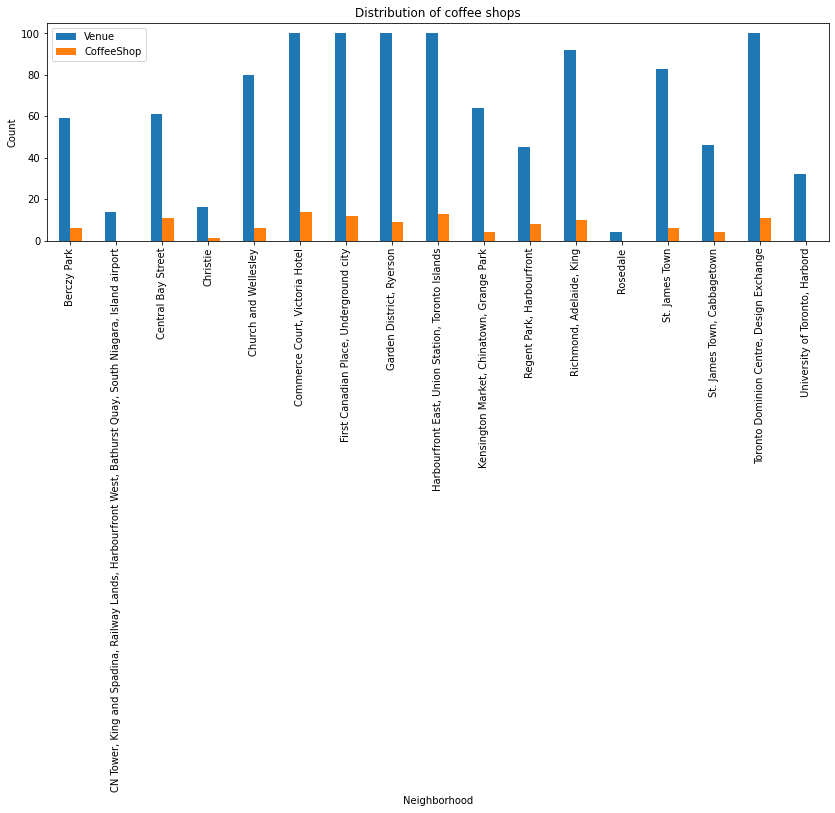

In [18]:
Coffee_data[['Venue','CoffeeShop']].plot(kind='bar', figsize=(14, 4))

label_list = Coffee_data['Neighborhood']
x=np.arange(label_list.size)
plt.xticks(x, label_list)
plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Count') # add y-label to the plot
plt.title('Distribution of coffee shops') # add title to the plot


plt.show()

*The third step : Calculate the percentage of coffee shops*

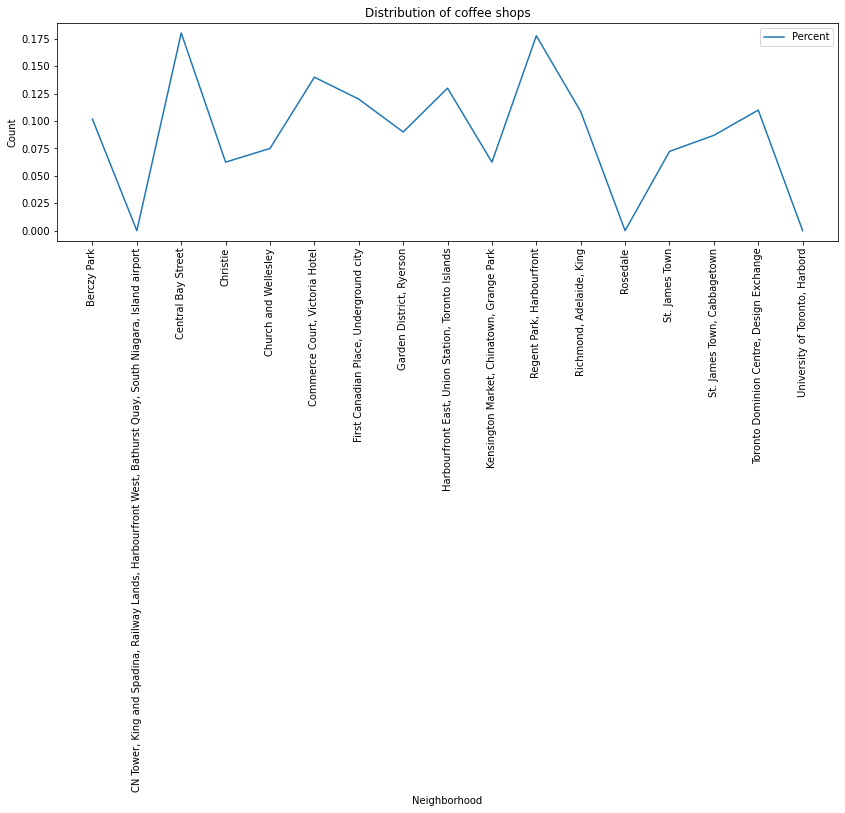

In [19]:
Coffee_data[['Percent']].plot(kind='line', figsize=(14, 4))

label_list = Coffee_data['Neighborhood']
x=np.arange(label_list.size)
plt.xticks(x, label_list,rotation=90)
plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Count') # add y-label to the plot
plt.title('Distribution of coffee shops') # add title to the plot

plt.show()

## Results section where you discuss the results

Through the establishment and calculation of the model, the following four results can be obtained:
1. There are Neighborhoods without coffee shops:"Rosedale","CN Tower, King and Spadina, Railway Lands,AirPort","University of Toronto, Harbord"
2. Except for the Neighborhoods without coffee shops, the Neighborhoods with the fewest coffee shops is:"Christie", the number is: 1.
3. Except for the Neighborhoods without coffee shops, the Neighborhoods with the least proportion of coffee shops are:"Christie" and "Kensington Market, Chinatown, Grange Park", and the proportion is:6.25%.
4. Except for the Neighborhoods without coffee shops, the Neighborhoods where the number and proportion of coffee shops are relatively small are:"Christie","Church and Wellesley","Kensington Market, Chinatown, Grange Park","St. James Town","St. James Town, Cabbagetown", number:<=6 & proportion:<10%. 

## Discussion and Recommendations section

Based on the above results, the following suggestions can be drawn:
1. For Neighborhoods without coffee shops, it is necessary to consider whether there is any inaccurate data acquisition. If data issues are excluded, it is recommended to choose to open coffee shops in Neighborhoods without coffee shops, unless the Neighborhood does not allow them to be established.
2. Comparing the analysis of "small number and small proportion", The small proportion can more accurately describe the unsaturation of the coffee shop in the Neighborhood, so priority is given to opening a coffee shop in  "Christie" and "Kensington Market, Chinatown, Grange Park" Neighborhoods
3. Neighborhoods with relatively small numbers and proportions can also be used as candidate Neighborhoods to focus on. 

## Conclusion section

print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

In [170]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
#toronto_onehot.drop(columns=['Neighborhood'], inplace=True)
toronto_onehot.head()

,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

*Integrate the distribution data of venues*

In [171]:

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()


,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [172]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(17, 203)


,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.016949,0.000000,0.0,0.0,0.0000,0.0,0.0000,0.016949,0.050847,0.000000,0.0,0.0,0.016949,0.016949,0.0,0.033898,0.0,0.0,0.016949,0.000000,0.000000,0.000000,0.0,0.016949,0.0,0.000000,0.000000,0.000000,0.0,0.016949,0.0000,0.000000,0.033898,0.0,0.0,0.0,0.016949,0.067797,0.101695,0.0,0.0,0.0,0.0,0.016949,0.000000,0.016949,0.0,0.0,0.016949,0.0,0.000000,0.000000,0.016949,0.0,0.016949,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.016949,0.0,0.000000,0.000000,0.0,0.000000,0.033898,0.000000,0.0,0.016949,0.000000,0.0,0.0,0.016949,0.016949,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.016949,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.016949,0.0,0.0,0.000000,0.016949,0.0,0.0,0.000000,0.016949,0.016949,0.0,0.016949,0.000000,0.0,0.0,0.0,0.016949,0.016949,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.016949,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.016949,0.0,0.000000,0.033898,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0

In [173]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
          venue  freq
0   Coffee Shop  0.10
1  Cocktail Bar  0.07
2        Bakery  0.05
3      Beer Bar  0.03
4      Pharmacy  0.03


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0    Airport Lounge  0.14
1   Airport Service  0.14
2  Airport Terminal  0.14
3  Sculpture Garden  0.07
4   Harbor / Marina  0.07


----Central Bay Street----
                 venue  freq
0          Coffee Shop  0.18
1                 Café  0.06
2   Italian Restaurant  0.05
3       Sandwich Place  0.05
4  Japanese Restaurant  0.03


----Christie----
                venue  freq
0       Grocery Store  0.25
1                Café  0.19
2                Park  0.12
3  Italian Restaurant  0.06
4         Candy Store  0.06


----Church and Wellesley----
                 venue  freq
0          Coffee Shop  0.08
1     Sushi Restaurant  0.06
2  Japanese Restaurant  0.06
3           Restaurant  0.04
4        

In [174]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [175]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Beer Bar,Restaurant,Farmers Market,Seafood Restaurant,Cheese Shop,Pharmacy,Indian Restaurant
1,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Terminal,Airport Lounge,Airport Service,Plane,Boutique,Rental Car Location,Boat or Ferry,Harbor / Marina,Sculpture Garden,Airport
2,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Salad Place,Bank,Bubble Tea Shop,Burger Joint,Thai Restaurant,Japanese Restaurant
3,Christie,Grocery Store,Café,Park,Athletics & Sports,Italian Restaurant,Nightclub,Candy Store,Restaurant,Baby Store,Coffee Shop
4,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Mediterranean Restaurant,Hotel,Yoga Studio,Men's Store,Pub


*Run k-means to cluster the neighborhood into 6 clusters.*

In [176]:
# set number of clusters
kclusters = 6

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 5, 1, 3, 4, 1, 1, 4, 1, 4], dtype=int32)

In [177]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_geo

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",43.6542599,-79.3606359,4,Coffee Shop,Bakery,Park,Restaurant,Breakfast Spot,Pub,Café,Theater,Mexican Restaurant,Beer Store
1,Downtown Toronto,"Garden District, Ryerson",43.6571618,-79.3789371,4,Clothing Store,Coffee Shop,Cosmetics Shop,Bubble Tea Shop,Café,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant,Hotel,Fast Food Restaurant
2,Downtown Toronto,St. James Town,43.6514939,-79.3754179,4,Coffee Shop,Café,Gastropub,Cocktail Bar,Creperie,Restaurant,Department Store,Cosmetics Shop,Clothing Store,Gym
3,Downtown Toronto,Berczy Park,43.6447708,-79.3733064,4,Coffee Shop,Cocktail Bar,Bakery,Beer Bar,Restaurant,Farmers Market,Seafood Restaurant,Cheese Shop,Pharmacy,Indian Restaurant
4,Downtown Toronto,Central Bay Street,43.6579524,-79.3873826,1,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Salad Place,Bank,Bubble Tea Shop,Burger Joint,Thai Restaurant,Japanese Restaurant


In [178]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

*Examine each cluster and determine the discriminating venue categories that distinguish each cluster*

In [180]:
toronto_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",43.6542599,-79.3606359,4,Coffee Shop,Bakery,Park,Restaurant,Breakfast Spot,Pub,Café,Theater,Mexican Restaurant,Beer Store
1,Downtown Toronto,"Garden District, Ryerson",43.6571618,-79.3789371,4,Clothing Store,Coffee Shop,Cosmetics Shop,Bubble Tea Shop,Café,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant,Hotel,Fast Food Restaurant
2,Downtown Toronto,St. James Town,43.6514939,-79.3754179,4,Coffee Shop,Café,Gastropub,Cocktail Bar,Creperie,Restaurant,Department Store,Cosmetics Shop,Clothing Store,Gym
3,Downtown Toronto,Berczy Park,43.6447708,-79.3733064,4,Coffee Shop,Cocktail Bar,Bakery,Beer Bar,Restaurant,Farmers Market,Seafood Restaurant,Cheese Shop,Pharmacy,Indian Restaurant
4,Downtown Toronto,Central Bay Street,43.6579524,-79.3873826,1,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Salad Place,Bank,Bubble Tea Shop,Burger Joint,Thai Restaurant,Japanese Restaurant


In [179]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Rosedale,Trail,Playground,Dance Studio,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store


In [130]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Rosedale,Trail,Playground,Dance Studio,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store


In [131]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Plane,Airport Terminal,Rental Car Location,Boat or Ferry,Harbor / Marina,Coffee Shop,Sculpture Garden,Airport Gate


In [132]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Christie,Café,Park,Athletics & Sports,Italian Restaurant,Nightclub,Candy Store,Restaurant,Baby Store,Coffee Shop


In [133]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Bay Street,Sandwich Place,Café,Italian Restaurant,Bank,Salad Place,Thai Restaurant,Japanese Restaurant,Burger Joint,Bubble Tea Shop
6,"Richmond, Adelaide, King",Café,Restaurant,Clothing Store,Deli / Bodega,Gym,Thai Restaurant,Hotel,Sushi Restaurant,Seafood Restaurant
7,"Harbourfront East, Union Station, Toronto Islands",Aquarium,Hotel,Café,Restaurant,Brewery,Italian Restaurant,Fried Chicken Joint,Scenic Lookout,Pizza Place
8,"Toronto Dominion Centre, Design Exchange",Hotel,Café,Japanese Restaurant,Salad Place,Italian Restaurant,Seafood Restaurant,Restaurant,Concert Hall,American Restaurant
9,"Commerce Court, Victoria Hotel",Restaurant,Hotel,Café,Italian Restaurant,Gym,American Restaurant,Japanese Restaurant,Deli / Bodega,Cocktail Bar
14,"St. James Town, Cabbagetown",Bakery,Restaurant,Café,Italian Restaurant,Pet Store,Pub,Pizza Place,Butcher,Japanese Restaurant
15,"First Canadian Place, Underground city",Café,Hotel,Japanese Restaurant,Gym,Restaurant,Seafood Restaurant,Asian Restaurant,Deli / Bodega,Steakhouse


In [134]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,"University of Toronto, Harbord",Bar,Japanese Restaurant,Bookstore,Bakery,Yoga Studio,Restaurant,Italian Restaurant,Beer Bar,Sandwich Place
